# Tutorial IV: Convolutions

<p>
Bern Winter School on Machine Learning, 2022<br>
Prepared by Mykhailo Vladymyrov.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will look at the convolutoin operation and try to build some intuition about it.
Also we will look at one of the state-of-the art deep models, [Inception](https://arxiv.org/abs/1602.07261). It is designed to perform image recognition.

## 1. Load necessary libraries

In [1]:
colab = True # set to True is using google colab

In [2]:
if colab:
    %tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
import os
import sys
import shutil
import tarfile

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from scipy.ndimage import rotate

# We'll tell matplotlib to inline any drawn figures like so:

%load_ext tensorboard

### Download libraries

In [ ]:
if colab:
    path = os.path.abspath('.')+'/material.tgz'
    url = 'https://github.com/neworldemancer/BMLWS/raw/main/tut_files/tpub0320.tgz'
    p = tf.keras.utils.get_file(path, url)
    assert p==path
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()

81207979/81207979 [==============================] - 1s 0us/step


In [ ]:
from utils import gr_disp
from utils import inception

In [ ]:
def show_graph(g=None, gd=None):
    gr_disp.show_graph(g, gd)
    %tensorboard --logdir logs

## 2. Images

What is an image?

## 3. Convolutions

In fully connected network all inputs of a layer are connected to all neurons of the following layer:
<tr>
    <td> <img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/Perceptron.png" alt="drawing" width="30%"/></td> 
    <td> <img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/MLP.png" alt="drawing" width="50%"/></td> 
</tr> 
<br>In convolutional nets the same holds for each neighbourhood, and the weights are shared:<br>
<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/CNN1.png" alt="drawing" width="50%"/><br>
look at neighborhoods separately (e.g. 3x3 pixels). Normally you preserve the neighborhoods / dimensions over the layers
1 neuron produces one new channel (1 new map layer / feature map)

<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/CNN2.png" alt="drawing" width="50%"/><br>
<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/CNN3.png" alt="drawing" width="50%"/><br>


Let's see what a convolution is, and how it behaves.



### 1.1. Handkrafting filters

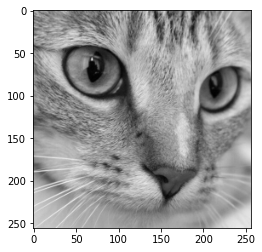

In [ ]:
#load image, convert to gray-scale and normalize
img_raw = plt.imread('ML3/chelsea.jpg').mean(axis=2)[-256:, 100:356].astype(np.float32)
img_raw = (img_raw-img_raw.mean())/img_raw.std()

plt.imshow(img_raw, cmap='gray')
plt.grid(False)

In [ ]:
x = tf.keras.layers.Input(dtype=tf.float32, shape=(None,None,1),name='img')
flt = tf.keras.layers.Input(dtype=tf.float32, shape=(None,None,1,1), name='flt')[0]  # (h, w, n_in_ch, n_out_ch)

stride = 1
dilation = 1

padding = 'VALID'
y1 = tf.nn.conv2d(x , flt, strides=[1,stride,stride,1], dilations=[1,dilation,dilation,1], padding=padding, name='y1')
y2 = tf.nn.conv2d(y1, flt, strides=[1,stride,stride,1], dilations=[1,dilation,dilation,1], padding=padding, name='y2')
y3 = tf.nn.conv2d(y2, flt, strides=[1,stride,stride,1], dilations=[1,dilation,dilation,1], padding=padding, name='y3')
y4 = tf.nn.conv2d(y3, flt, strides=[1,stride,stride,1], dilations=[1,dilation,dilation,1], padding=padding, name='y4')

model = tf.keras.Model(inputs=[x, flt], outputs=[x*1, y1, y2, y3, y4])

In [ ]:
def get_convolved(img, flt):
  img_raw4d = img[np.newaxis,...,np.newaxis]
  
  flt_mtx_np = np.array(flt_mtx, np.float32)
  flt_mtx_np = flt_mtx_np[..., np.newaxis, np.newaxis]
  
  res = model((img_raw4d, flt_mtx_np))
  res = [r[0,...,0].numpy() for r in res]

  return res

Let's experiment with filter kernels:

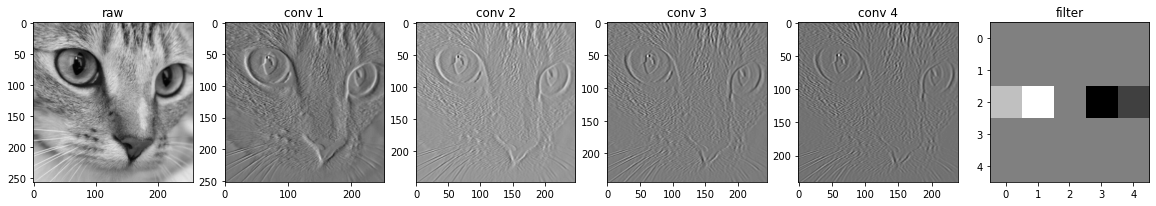

In [ ]:
flt_mtx = [
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 0, 0, 0,],
] # identity transformation

ims_convolves = get_convolved(img_raw, flt_mtx)

n = len(ims_convolves)
fig, ax = plt.subplots(1, n+1, figsize=(n*4, 4))
for col in range(n):
    ax[col].imshow(ims_convolves[col], cmap='gray')  #, vmin=-3, vmax=3
    ax[col].grid(False)
    ax[col].set_title('conv %d'% col if col else 'raw')

ax[n].imshow(flt_mtx, cmap='gray')
ax[n].grid(False)
_=ax[n].set_title('filter')

### 1.2. Most common filters

Here are most common filter kernels, in 1D:

|filter type| effect|
|-----|-----|
|gaussian| bluring|
|first derivative of gaussian|detection of edges|
|second derivative of gaussian|detection of peaks|


In [ ]:
def gaussian(n=5):
    x = np.linspace(-3, 3, n)
    y = np.exp(-x**2 * 0.5) / np.sqrt(2*np.pi)
    return y

def dgaussian(n=5):
    x = np.linspace(-3, 3, n)
    y = - 2 * x * np.exp(-x**2 * 0.5) / np.sqrt(2*np.pi)
    return y

def ddgaussian(n=5):
    x = np.linspace(-3, 3, n)
    y = - 2 * (2*x**2 - 1) * np.exp(-x**2 * 0.5) / np.sqrt(2*np.pi)
    return y
  
def ddgaussian2d(n=5):
    c = np.linspace(-3, 3, n)
    r = np.asarray([[np.sqrt(xi**2+yi**2) for xi in c] for yi in c])
    f = lambda x: (- 2 * (2*x**2 - 1) * np.exp(-x**2 * 0.5) / np.sqrt(2*np.pi))

    y = f(r)
    y -= y.mean()
    return y

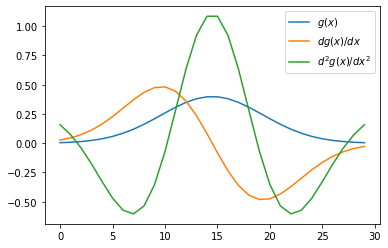

In [ ]:
n = 30

gf = np.tile(gaussian(n)[np.newaxis], [n, 1])

dgf = np.tile(dgaussian(n)[np.newaxis], [n, 1])

ddgf = ddgaussian(n)
ddgf -= ddgf.mean()
ddgf = np.tile(ddgf[np.newaxis], [n, 1])

ddgf2d = ddgaussian2d(n)
rf2d = lambda:  np.random.normal(size=(5,5))


plt.plot(gf[0], label=r'$g(x)$')
plt.plot(dgf[0], label=r'$d g(x)/dx$')
plt.plot(ddgf[0], label=r'$d^2 g(x)/dx^2$')
plt.legend();

Gabor filter is a gaussian in one direction, and a derivative of gaussin on the other:

In [ ]:
gf.shape

(30, 30)

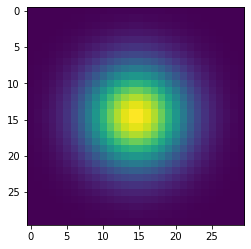

In [ ]:
flt_mtx = gf*gf.transpose()

#flt_mtx = rotate(flt_mtx, 30, reshape=False)

plt.imshow(flt_mtx)
plt.grid(False)

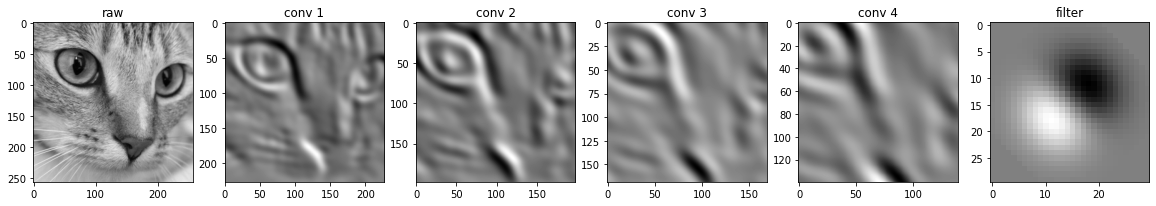

In [ ]:
#flt_mtx = gf*gf.transpose()    # gaussian filter
flt_mtx = dgf*gf.transpose()   # gabor filter, 1st derivative of gaussian (edge detection)
#flt_mtx = ddgf*gf.transpose()  # 2nd derivative of gaussian (line detection)
#flt_mtx = ddgf2d               # 2nd derivative of gaussian, central symmetric, (spot detection)

flt_mtx = rotate(flt_mtx, 45, reshape=False)

ims_convolves = get_convolved(img_raw, flt_mtx)

n = len(ims_convolves)
fig, ax = plt.subplots(1, n+1, figsize=(n*4, 4))
for col in range(n):
    ax[col].imshow(ims_convolves[col], cmap='gray')  #, vmin=-3, vmax=3
    ax[col].grid(False)
    ax[col].set_title('conv %d'% col if col else 'raw')

ax[n].imshow(flt_mtx, cmap='gray')
ax[n].grid(False)
_=ax[n].set_title('filter')

## 4. Exercise 20 min

Experiment with filters, try random, try to amplify some specific pattern eg whiskers or pupil, or perhaps make animation of filter effect depending on some parameter - e.g. size, angle, etc.

## 4. Homework

In last session we used fully connected network to clasify digits.
Try to build the convolutional network: use three convolutional layers, then flatten the ouput and apply 1 fully connected.
You can use the following helper function. Notice: there is a stride parameter. It allows to effectively downscale the feature maps.
To get an understanding of different convolution types, check the <a href="https://github.com/vdumoulin/conv_arithmetic">animations here</a>.

You can start with something like this:


In [ ]:
...
x_train = x_train_2d[..., np.newaxis]  # we need additional channel dimension, to get 4D (BHWC) dataset

....

x = tf.keras.layers.Input(shape=(28, 28, 1))

l1 = tf.keras.layers.Conv2D(16, 3, name = 'C1', kernel_initializer='he_uniform', activation='relu')(x)
l2 = tf.keras.layers.Conv2D(32, 3, strides=2, name = 'C2', kernel_initializer='he_uniform', activation='relu')(l1)
l3 = tf.keras.layers.Conv2D(32, 3, strides=2, name = 'C3', kernel_initializer='he_uniform', activation='relu')(l2)

l3_f = tf.keras.layers.Flatten()(l3)

l4 = tf.keras.layers.Dense(units=32, name='l4', activation='relu')(l3_f)
l5 = tf.keras.layers.Dense(units=10, name='l5', activation='softmax')(l4)

Play with layer parameters. Can you get better performance than in fully connected network?

## 5. Load the model

Let's check some pretrained models

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=True) # ResNet50V2

In [ ]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

## 6. Test the model

We will use one image to check model. `img_preproc` is croped to 299x299 pixels and slightly transformed to be used as imput for the model using `inception.prepare_training_img`. `inception.training_img_to_display` is then used to convert it to displayable one.


In [ ]:
sz = 299
img_raw = plt.imread('ML3/chelsea.jpg')

img_crop = img_raw.copy()[:sz, 100:100+sz]

_, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(img_raw)
axs[0].grid(False)
axs[1].imshow(img_crop)
axs[1].grid(False)
plt.show()

We need to apply same scaling to the input asa was done for training samples. This is done with a `preprocess_input` method corresponding to a model

In [ ]:
img_preproc = tf.keras.applications.inception_v3.preprocess_input(img_crop)   #resnet_v2

We then obtain probabilities of each class on this image:

In [ ]:
pred = base_model.predict(img_preproc[np.newaxis])

In [ ]:
tf.keras.applications.inception_v3.decode_predictions(pred, top=5)  #resnet_v2

In [ ]:
all_preds = tf.keras.applications.inception_v3.decode_predictions(pred, top=-1)  #resnet_v2
plt.semilogy([prob for class_id, class_name, prob in all_preds[0]], '.');